In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot

from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import *

In [17]:
def read_tag_from_wandb(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        if 'val_dice_scores/class_Unknown' not in dicto.keys() or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[['label', 'val_dice_score', 'num_samples_per_epoch']]

    #assert ret_df.shape[0] == 102
    assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

In [24]:
medsam_finetune_df = read_tag_from_wandb(tag = 'medsam', project_name = 'MedSAM_finetune_hcp_ya_second_round_with_bbox')
yolov7_finetune_df = read_tag_from_wandb(tag = 'yolov7', project_name = 'MedSAM_finetune_hcp_ya_second_round_with_bbox')
constant_bbox_finetune_df = read_tag_from_wandb(tag = 'constant_bbox', project_name = 'MedSAM_finetune_hcp_ya_second_round_with_bbox')
constant_bbox_finetune_df.columns = ['label', 'val_dice_score_constantbbox', 'num_samples_per_epoch_constantbbox']

merged = medsam_finetune_df.merge(yolov7_finetune_df, how='inner', on='label', suffixes=['_medsam', '_yolov7'])
merged = merged.merge(constant_bbox_finetune_df, how='inner', on='label')

multitask_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/models_8-9-23/scratch_loss_reweighted_lr1e-4_ce_only_longer3_model_20230804-133537/scratch_loss_reweighted_lr1e-4_ce_only_longer3_validation_dice_scores_1.6million_samples.csv', names = ['label', 'label_name', 'val_dice_score_multitask'], header=0)
multitask_df = multitask_df.sort_values('label')[1:].reset_index(drop=True) # drop unknown row
merged = merged.merge(multitask_df, how='inner', on='label')

yolov7_longer_finetune_df = read_tag_from_wandb(tag = 'singletask_longer', project_name = 'MedSAM_finetune_final_round', min_epoch_cutoff=58)
yolov7_longer_2 = read_tag_from_wandb(tag = 'singletask_longer', project_name = 'MedSAM_finetune_hcp_ya_second_round_with_bbox', min_epoch_cutoff=58)
if yolov7_longer_2.shape[0] > 0:
    yolov7_longer_finetune_df = pd.concat([yolov7_longer_finetune_df, yolov7_longer_2])
yolov7_longer_finetune_df['num_samples_per_epoch'] *= 2 # because epochs are 31..60 but we divided by 60, not 30
yolov7_longer_finetune_df.columns = ['label', 'val_dice_score_yolov7_longer', 'num_samples_per_epoch_yolov7_longer']
merged = merged.merge(yolov7_longer_finetune_df, how='inner', on='label')

df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)
merged['label_name'] = label_converter.compressed_to_name(merged['label'])
merged = merged[['label', 'label_name'] + [col for col in merged.columns if col not in ['label', 'label_name']]]
merged


,label,label_name,val_dice_score_medsam,num_samples_per_epoch_medsam,val_dice_score_yolov7,num_samples_per_epoch_yolov7,val_dice_score_constantbbox,num_samples_per_epoch_constantbbox,val_dice_score_multitask,val_dice_score_yolov7_longer,num_samples_per_epoch_yolov7_longer
0,1,Left-Cerebral-White-Matter,0.827881,101850,0.839055,96532,0.832331,95792,0.799817,0.893100,96532
1,2,Left-Lateral-Ventricle,0.805776,25889,0.821219,24944,0.757189,25889,0.794213,0.878499,24944
2,3,Left-Inf-Lat-Vent,0.526445,11356,0.547764,6346,0.222655,11356,0.493712,0.757968,6346
3,4,Left-Cerebellum-White-Matter,0.673706,33675,0.622283,36553,0.611897,33675,0.552343,0.750375,36552
4,5,Left-Cerebellum-Cortex,0.859397,53263,0.869117,52707,0.823429,53263,0.793327,0.893976,52706
...,...,...,...,...,...,...,...,...,...,...,...
97,98,ctx-rh-superiorparietal,0.622212,49973,0.648758,48913,0.543173,49973,0.576668,0.756455,48912
98,99,ctx-rh-superiortemporal,0.696306,47952,0.686438,48092,0.643358,45080,0.586505,0.769723,48092
99,100,ctx-rh-supramarginal,0.642722,36465,0.637834,37394,0.535619,36465,0.595278,0.754256,37394
100,101,ctx-rh-transversetemporal,0.543863,14305,0.624099,13605,0.407994,14305,0.515972,0.734255,13604


In [16]:
stuff = sns.color_palette('vlag', n_colors = 102)

(0.18382538, 0.43044226, 0.73776764)

<Axes: xlabel='val_dice_score_yolov7_longer', ylabel='label_name'>

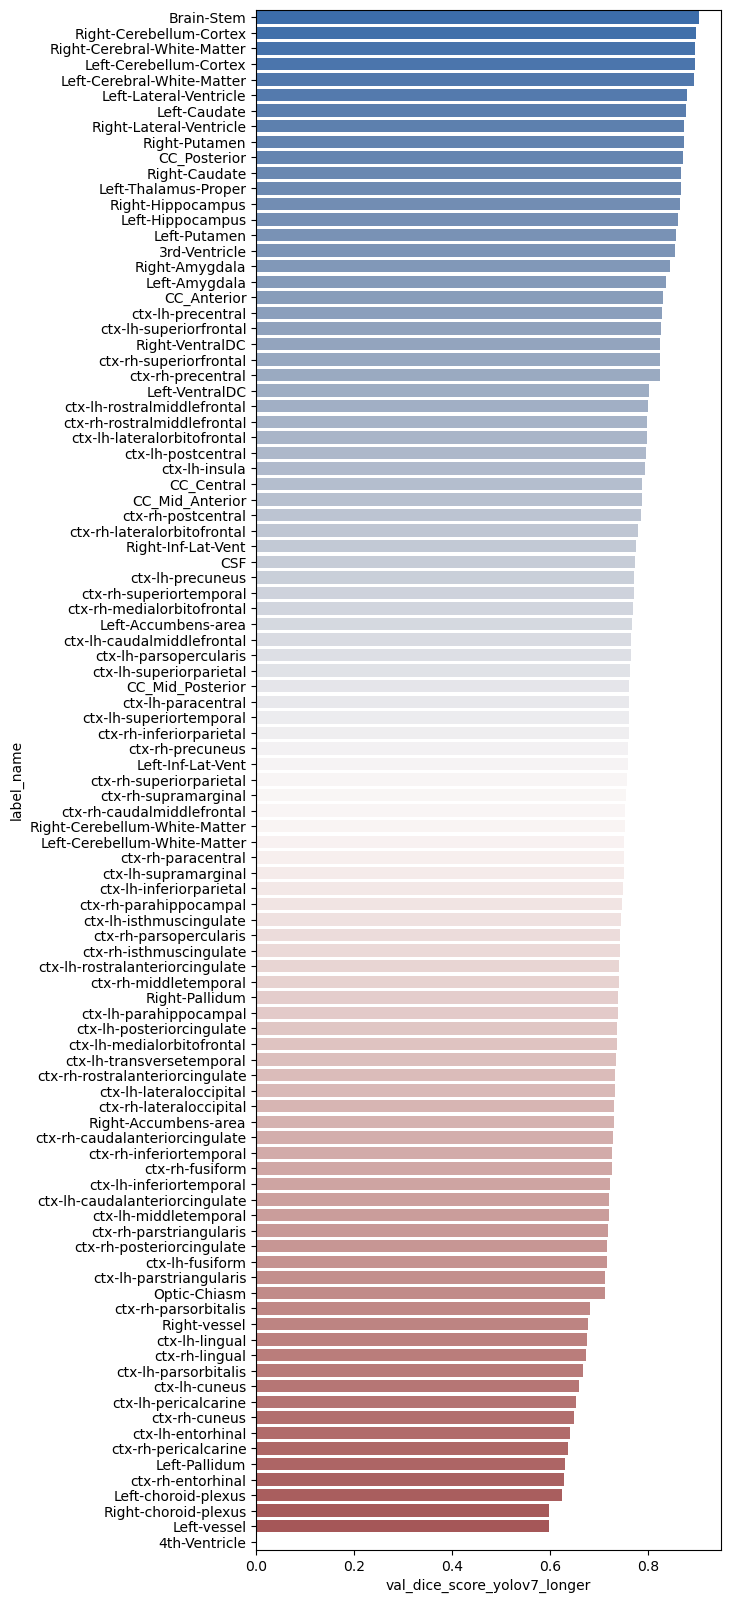

In [19]:
f, ax = plt.subplots(figsize = (6,20))
sns.set_color_codes("pastel")
merged_sorted = merged.sort_values('val_dice_score_yolov7_longer', ascending=False)
sns.barplot(x = 'val_dice_score_yolov7_longer', y = 'label_name', data = merged_sorted, palette = stuff)

### Generate long df

In [25]:
# generate long df
merged_long = pd.melt(merged, id_vars = ['label', 'label_name'], 
                    value_vars = ['val_dice_score_medsam', 'val_dice_score_yolov7', 'val_dice_score_constantbbox', 'val_dice_score_multitask', 'val_dice_score_yolov7_longer'],
                    var_name = 'method', value_name = 'val_dice_score'
                    )
mapper = {'val_dice_score_medsam': 'medsam', 'val_dice_score_yolov7': 'yolov7', 'val_dice_score_constantbbox': 'constantbbox', 'val_dice_score_multitask': 'multitask', 'val_dice_score_yolov7_longer': 'yolov7_longer'}
merged_long['method'] = merged_long['method'].map(mapper)

# second melt
melted_num_samples_df = pd.melt(merged, id_vars = ['label', 'label_name'], 
                    value_vars = ['num_samples_per_epoch_medsam', 'num_samples_per_epoch_yolov7', 'num_samples_per_epoch_constantbbox', 'num_samples_per_epoch_yolov7_longer'],
                    var_name = 'method', value_name = 'num_samples_per_epoch'
                    )
mapper2 = {'num_samples_per_epoch_medsam': 'medsam', 'num_samples_per_epoch_yolov7': 'yolov7', 'num_samples_per_epoch_constantbbox': 'constantbbox', 'num_samples_per_epoch_yolov7_longer':'yolov7_longer'}
melted_num_samples_df['method'] = melted_num_samples_df['method'].map(mapper2)



merged_long = merged_long.merge(melted_num_samples_df, how = 'left', on=['label', 'label_name', 'method'])

merged_long

,label,label_name,method,val_dice_score,num_samples_per_epoch
0,1,Left-Cerebral-White-Matter,medsam,0.827881,101850.0
1,2,Left-Lateral-Ventricle,medsam,0.805776,25889.0
2,3,Left-Inf-Lat-Vent,medsam,0.526445,11356.0
3,4,Left-Cerebellum-White-Matter,medsam,0.673706,33675.0
4,5,Left-Cerebellum-Cortex,medsam,0.859397,53263.0
...,...,...,...,...,...
505,98,ctx-rh-superiorparietal,yolov7_longer,0.756455,48912.0
506,99,ctx-rh-superiortemporal,yolov7_longer,0.769723,48092.0
507,100,ctx-rh-supramarginal,yolov7_longer,0.754256,37394.0
508,101,ctx-rh-transversetemporal,yolov7_longer,0.734255,13604.0


### boxplot

In [33]:
merged_long['method']

0             medsam
1             medsam
2             medsam
3             medsam
4             medsam
           ...      
465    yolov7_longer
466    yolov7_longer
467    yolov7_longer
468    yolov7_longer
469    yolov7_longer
Name: method, Length: 470, dtype: object

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

singletask v.s. multitask: t-test paired samples with Bonferroni correction, P_val=4.386e-05 stat=-4.289e+00


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
 [<statannot.StatResult.StatResult at 0x2aabac545cc0>])

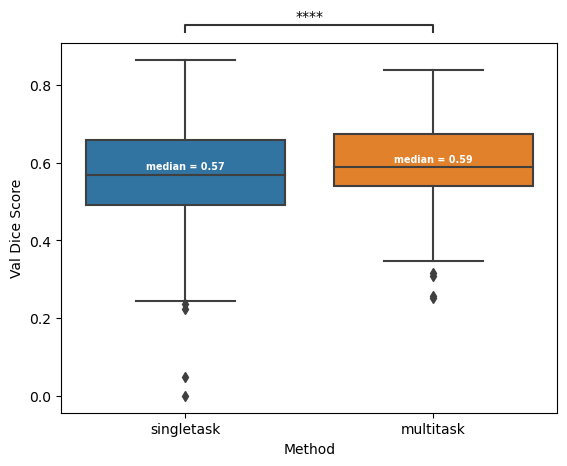

In [46]:
# plot boxes for just singletask vs multitask
xd = merged_long.copy()
xd['method'] = xd['method'].map({'constantbbox':'singletask','multitask':'multitask'})
box_plot = sns.boxplot(data = xd,
            x = 'method',
            y = 'val_dice_score',
            order = ['singletask', 'multitask']
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = xd.groupby('method')['val_dice_score'].median().reindex(index = ['singletask', 'multitask'])
vertical_offset = .02 * xd['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=xd,
    x='method',
    y='val_dice_score',
    order = ['singletask', 'multitask'],
    box_pairs=[
        ('singletask', 'multitask')
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

constantbbox v.s. multitask: t-test paired samples with Bonferroni correction, P_val=1.168e-04 stat=-4.379e+00
multitask v.s. medsam: t-test paired samples with Bonferroni correction, P_val=1.979e-12 stat=-8.295e+00
medsam v.s. yolov7: t-test paired samples with Bonferroni correction, P_val=7.512e-05 stat=-4.492e+00
yolov7 v.s. yolov7_longer: t-test paired samples with Bonferroni correction, P_val=3.917e-12 stat=-8.158e+00


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
  <statannot.StatResult.StatResult at 0x2aabb0d82050>])

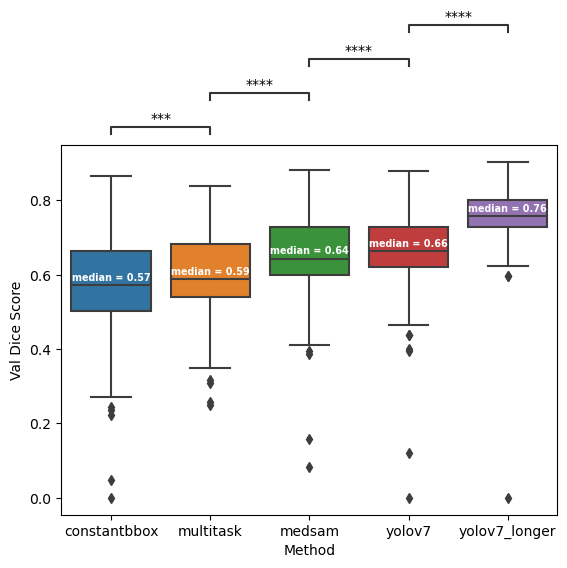

In [26]:
# is there significant difference in how well these methods perform?

box_plot = sns.boxplot(data = merged_long,
            x = 'method',
            y = 'val_dice_score',
            order = ['constantbbox', 'multitask', 'medsam', 'yolov7', 'yolov7_longer']
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = merged_long.groupby('method')['val_dice_score'].median().reindex(index = ['constantbbox', 'multitask', 'medsam', 'yolov7', 'yolov7_longer'])
vertical_offset = .02 * merged_long['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=merged_long,
    x='method',
    y='val_dice_score',
    order = ['constantbbox', 'multitask', 'medsam', 'yolov7', 'yolov7_longer'],
    box_pairs=[
        ('constantbbox', 'multitask'),
        ('multitask', 'medsam'),
        ('medsam', 'yolov7'),
        ('yolov7', 'yolov7_longer')
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


In [27]:
merged_long

,label,label_name,method,val_dice_score,num_samples_per_epoch
0,1,Left-Cerebral-White-Matter,medsam,0.827881,101850.0
1,2,Left-Lateral-Ventricle,medsam,0.805776,25889.0
2,3,Left-Inf-Lat-Vent,medsam,0.526445,11356.0
3,4,Left-Cerebellum-White-Matter,medsam,0.673706,33675.0
4,5,Left-Cerebellum-Cortex,medsam,0.859397,53263.0
...,...,...,...,...,...
505,98,ctx-rh-superiorparietal,yolov7_longer,0.756455,48912.0
506,99,ctx-rh-superiortemporal,yolov7_longer,0.769723,48092.0
507,100,ctx-rh-supramarginal,yolov7_longer,0.754256,37394.0
508,101,ctx-rh-transversetemporal,yolov7_longer,0.734255,13604.0


     label                    label_name                       method  \
102      1    Left-Cerebral-White-Matter          single-task + boxes   
103      2        Left-Lateral-Ventricle          single-task + boxes   
104      3             Left-Inf-Lat-Vent          single-task + boxes   
105      4  Left-Cerebellum-White-Matter          single-task + boxes   
106      5        Left-Cerebellum-Cortex          single-task + boxes   
..     ...                           ...                          ...   
505     98       ctx-rh-superiorparietal  single-task + boxes, longer   
506     99       ctx-rh-superiortemporal  single-task + boxes, longer   
507    100          ctx-rh-supramarginal  single-task + boxes, longer   
508    101     ctx-rh-transversetemporal  single-task + boxes, longer   
509    102                 ctx-rh-insula  single-task + boxes, longer   

     val_dice_score  num_samples_per_epoch  
102        0.839055                96532.0  
103        0.821219              

(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
  <statannot.StatResult.StatResult at 0x2aabaead1e10>])

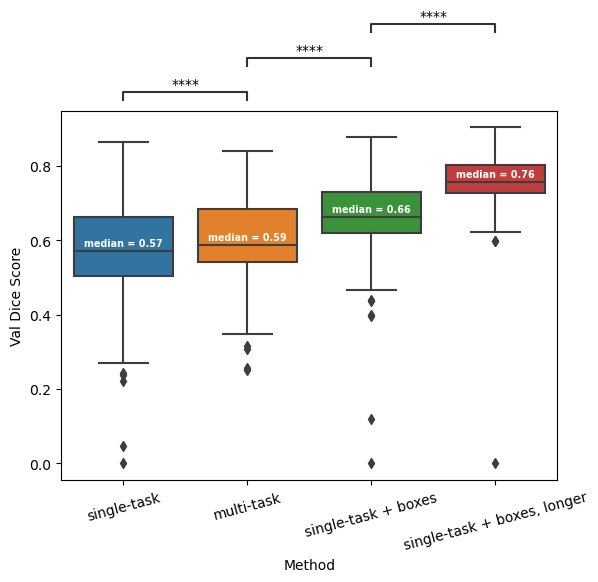

In [39]:
# is there significant difference in how well these methods perform?
# but use less methods
listo = ['constantbbox', 'multitask', 'yolov7', 'yolov7_longer']
dicto_transform = {
    'constantbbox' : 'single-task',
    'multitask': 'multi-task',
    'yolov7': 'single-task + boxes',
    'yolov7_longer': 'single-task + boxes, longer'
}


tmp = merged_long.loc[merged_long.method.isin(listo), :].copy()
tmp['method'] = tmp['method'].map(dicto_transform)
print(tmp)
listo = [dicto_transform[x] for x in listo]
box_plot = sns.boxplot(data = tmp,
            x = 'method',
            y = 'val_dice_score',
            order = listo
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = tmp.groupby('method')['val_dice_score'].median().reindex(index = listo)
vertical_offset = .02 * tmp['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=15)
statannot.add_stat_annotation(
    plt.gca(),
    data=tmp,
    x='method',
    y='val_dice_score',
    order = listo,
    box_pairs=[
        (listo[0], listo[1]),
        (listo[1], listo[2]),
        (listo[2], listo[3])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


### Scatterplot each method vs num_samples

Text(0.5, 28.999999999999986, 'Method')

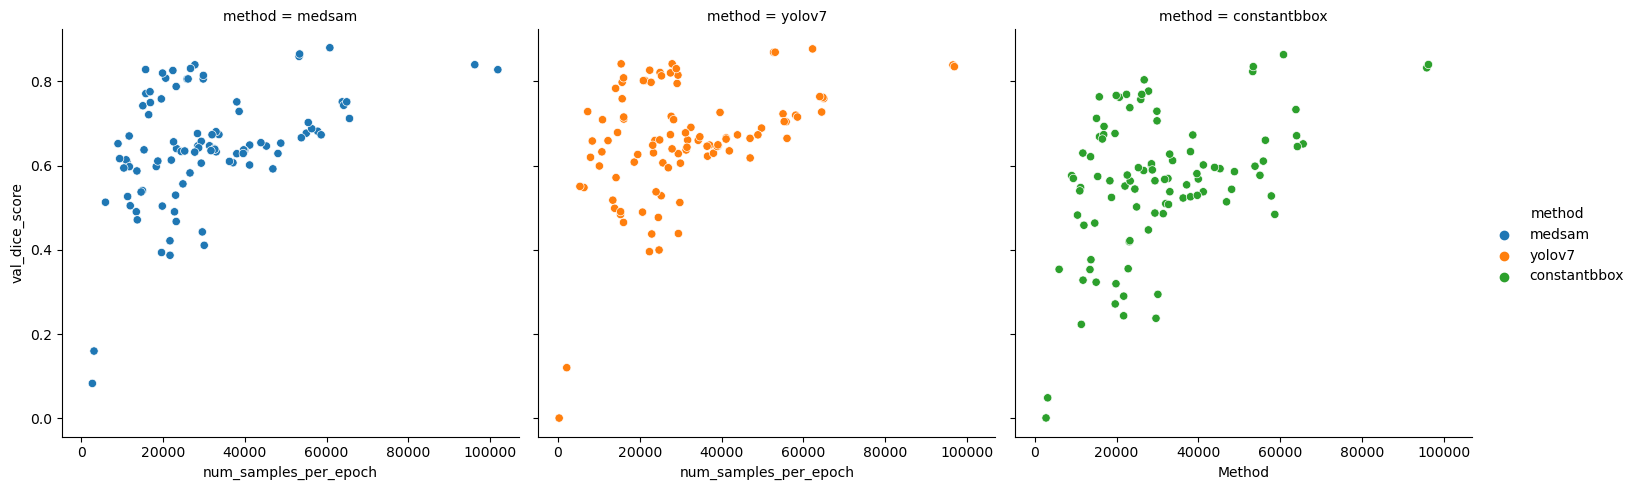

In [23]:
# how does each method behave with varying sample sizes

sns.relplot(data = merged_long,
            x = 'num_samples_per_epoch',
            y = 'val_dice_score',
            hue = 'method',
            col = 'method'
)
plt.ylabel('Val Dice Score')
plt.xlabel('Method')

Text(9.444444444444445, 0.5, 'Val Dice Score Yolov7')

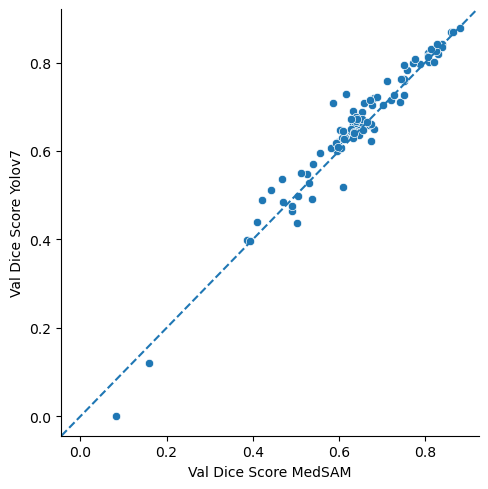

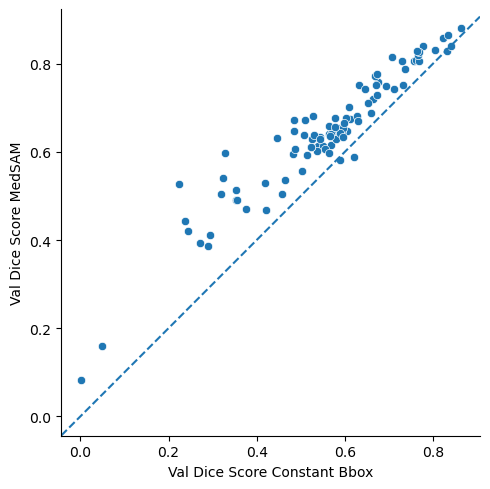

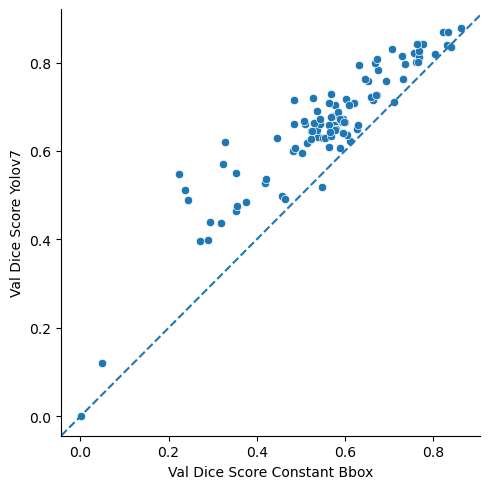

In [36]:
### Scatterplot each method dice score vs each other

# yolov7 vs medsam
g = sns.relplot(data = merged,
            x = 'val_dice_score_medsam', 
            y = 'val_dice_score_yolov7'
)

plt.axline((0, 0), slope=1, linestyle = '--')
plt.xlabel('Val Dice Score MedSAM')
plt.ylabel('Val Dice Score Yolov7')

# medsam vs constant bbox
g = sns.relplot(data = merged,
            x = 'val_dice_score_constantbbox', 
            y = 'val_dice_score_medsam'
)

plt.axline((0, 0), slope=1, linestyle = '--')
plt.xlabel('Val Dice Score Constant Bbox')
plt.ylabel('Val Dice Score MedSAM')

# yolov7 vs constant bbox
g = sns.relplot(data = merged,
            x = 'val_dice_score_constantbbox', 
            y = 'val_dice_score_yolov7'
)

plt.axline((0, 0), slope=1, linestyle = '--')
plt.xlabel('Val Dice Score Constant Bbox')
plt.ylabel('Val Dice Score Yolov7')


    label                       label_name  val_dice_score_medsam  \
0       1       Left-Cerebral-White-Matter               0.827881   
1       2           Left-Lateral-Ventricle               0.805776   
2       3                Left-Inf-Lat-Vent               0.526445   
3       4     Left-Cerebellum-White-Matter               0.673706   
4       5           Left-Cerebellum-Cortex               0.859397   
..    ...                              ...                    ...   
89     91               ctx-rh-postcentral               0.673066   
90     92        ctx-rh-posteriorcingulate               0.610721   
91     94                 ctx-rh-precuneus               0.666117   
92     95  ctx-rh-rostralanteriorcingulate               0.634632   
93    100             ctx-rh-supramarginal               0.642722   

    num_samples_per_epoch_medsam  val_dice_score_yolov7  \
0                         101850               0.839055   
1                          25889               0.8212

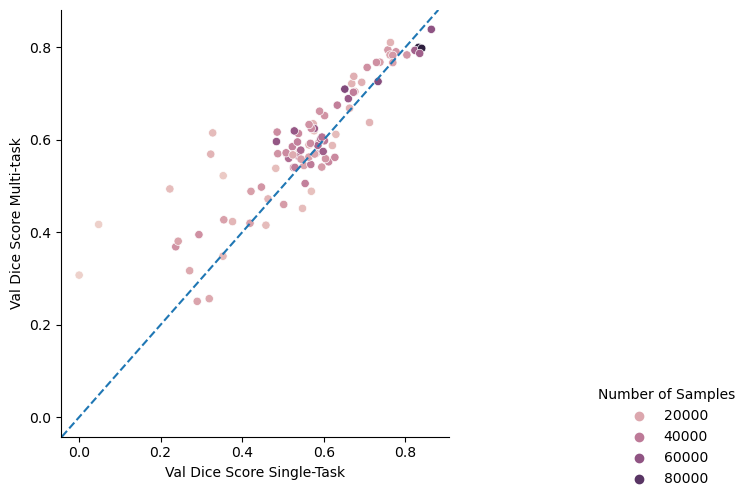

In [59]:
print(merged)
g = sns.relplot(data = merged,
            x = 'val_dice_score_constantbbox', 
            y = 'val_dice_score_multitask',
            hue='num_samples_per_epoch_constantbbox'
)

plt.axline((0, 0), slope=1, linestyle = '--')
plt.xlabel('Val Dice Score Single-Task')
plt.ylabel('Val Dice Score Multi-task')
sns.move_legend(g, title = 'Number of Samples', loc='lower right')